In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import PrecisionRecallDisplay, confusion_matrix

# Import models
from tensorflow import keras
from keras import models, layers, activations, losses, optimizers, metrics
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import matplotlib.pyplot as plt

keras.utils.set_random_seed(42)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
2023-10-25 09:22:36.200196: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('../data/all_data.csv', low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102562 entries, 0 to 102561
Data columns (total 63 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     102562 non-null  int64  
 1   src_bytes                    102562 non-null  int64  
 2   dst_bytes                    102562 non-null  int64  
 3   hot                          102562 non-null  int64  
 4   num_failed_logins            102562 non-null  int64  
 5   logged_in                    102562 non-null  int64  
 6   lnum_compromised             102562 non-null  int64  
 7   lroot_shell                  102562 non-null  int64  
 8   lsu_attempted                102562 non-null  int64  
 9   lnum_file_creations          102562 non-null  int64  
 10  lnum_shells                  102562 non-null  int64  
 11  lnum_access_files            102562 non-null  int64  
 12  is_guest_login               102562 non-null  int64  
 13 

In [3]:
X = df.drop(['anomaly'], axis = 1)
y = df['anomaly']

In [4]:
X_scaled = MinMaxScaler().fit_transform(X) 
X_scaled = pd.DataFrame(X_scaled)
X_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
0,102562.0,0.003962,0.026396,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.0
1,102562.0,0.000016,0.003128,0.0,2.091219e-07,3.273839e-07,4.499725e-07,1.0
2,102562.0,0.000777,0.014047,0.0,2.036673e-05,7.312624e-05,3.873557e-04,1.0
3,102562.0,0.004137,0.056302,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.0
4,102562.0,0.000146,0.006811,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.0
...,...,...,...,...,...,...,...,...
57,102562.0,0.000536,0.023151,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.0
58,102562.0,0.000185,0.013610,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.0
59,102562.0,0.000098,0.009874,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.0
60,102562.0,0.919454,0.272139,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.0


In [5]:
pca = PCA(n_components=2)
pca.fit(X_scaled)
print(pca.explained_variance_ratio_)
pca_X = pca.fit_transform(X_scaled)

[0.34304237 0.20075441]


In [6]:
pca_df = pd.DataFrame(pca_X, columns = ['component_1', 'component_2'])
pca_df['is_anomaly'] = y
display(pca_df)

,component_1,component_2,is_anomaly
0,-0.487906,0.073860,0
1,-0.502528,0.057736,0
2,-0.510092,0.044800,0
3,-0.514214,0.033278,0
4,-0.520015,0.021139,0
...,...,...,...
102557,-0.722214,-0.071913,0
102558,-0.742430,-0.000277,0
102559,-0.755605,-0.012203,0
102560,-0.753871,-0.024196,0


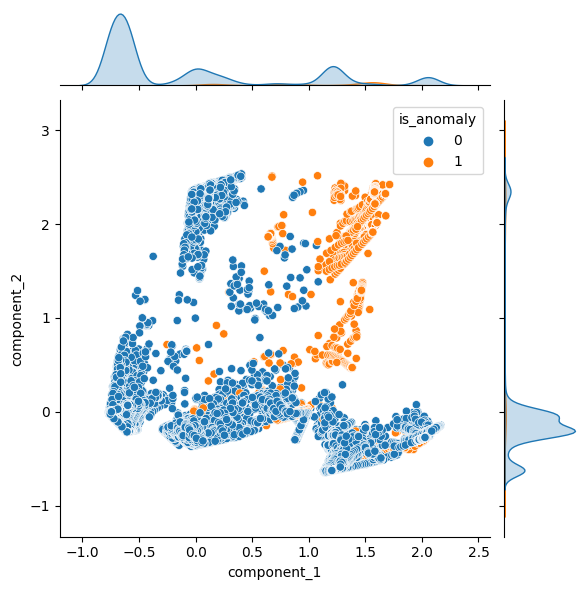

In [7]:
# Scatter plot of 2 features
sns.jointplot(data = pca_df, x="component_1", y="component_2", hue = "is_anomaly", kind='scatter')

In [8]:
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, 
                                                    random_state=42, stratify=df['anomaly'])

print(y_train.value_counts())
print(y_test.value_counts())

anomaly
0    77821
1     4228
Name: count, dtype: int64
anomaly
0    19456
1     1057
Name: count, dtype: int64


[[18534   922]
 [  304   753]]


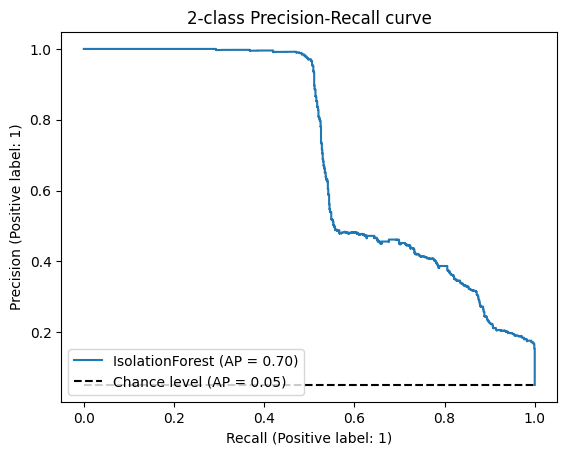

In [9]:
clf = IsolationForest(random_state=42).fit(X_train)

y_test_pred = clf.predict(X_test) * -1
y_test_pred[y_test_pred == -1] = 0
print(confusion_matrix(y_test, y_test_pred))

y_score = clf.decision_function(X_test) * -1

display = PrecisionRecallDisplay.from_predictions(
    y_test, y_score, name="IsolationForest", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

[[17036  2420]
 [  896   161]]


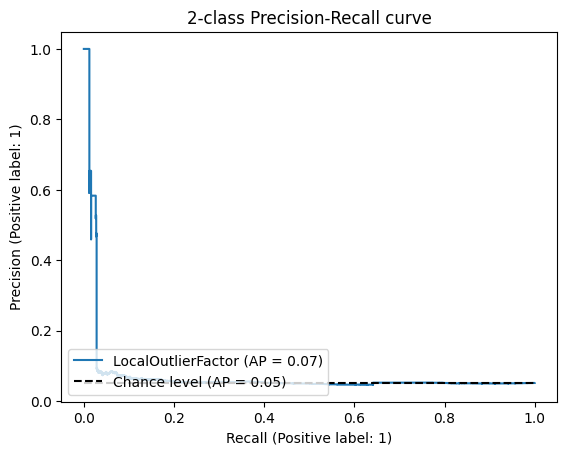

In [10]:
# define outlier detection model
clf = LocalOutlierFactor(novelty=True).fit(X_train)

y_test_pred = clf.predict(X_test) * -1
y_test_pred[y_test_pred == -1] = 0
print(confusion_matrix(y_test, y_test_pred))

y_score = clf.decision_function(X_test) * -1

display = PrecisionRecallDisplay.from_predictions(
    y_test, y_score, name="LocalOutlierFactor", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

[[19454     2]
 [  111   946]]


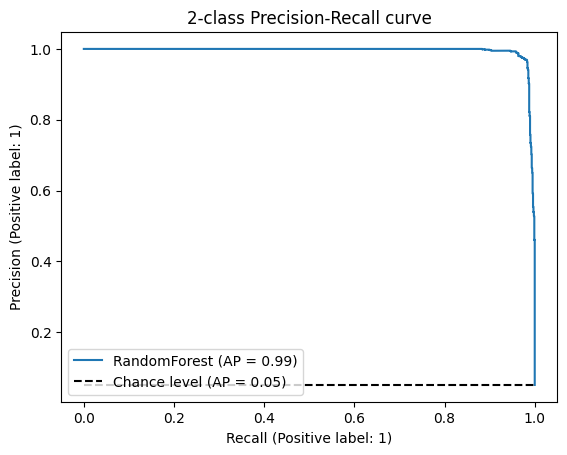

In [11]:
clf = RandomForestClassifier(n_estimators = 100, max_depth = 7, random_state=42).fit(X_train, y_train)

y_test_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))

y_score = clf.predict_proba(X_test)[:,1]

display = PrecisionRecallDisplay.from_predictions(
    y_test, y_score, name="RandomForest", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [12]:
clf = OneClassSVM(gamma='scale', nu=0.05)

[[75784  2037]
 [ 2265  1963]]
1963
80086
(82049, 62)
80086
(80086, 62)
(80086,)
[[75147  2674]
 [  939  1326]]
1326
78760
(80086, 62)
78760
(78760, 62)
(78760,)
[[74211  3610]
 [  549   390]]
390
78370
(78760, 62)
78370
(78370, 62)
(78370,)


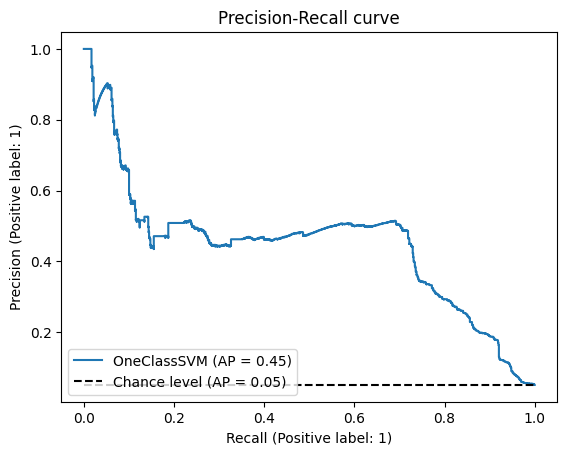

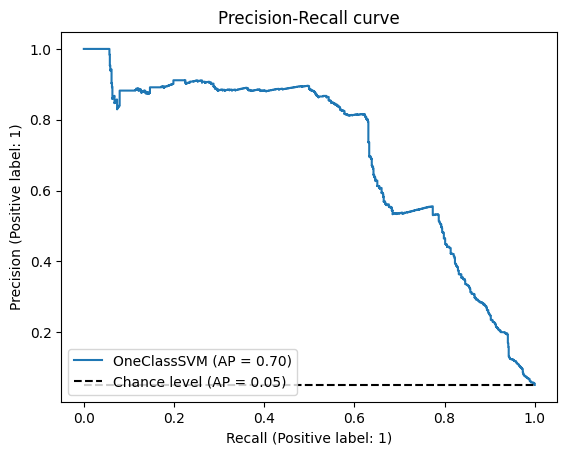

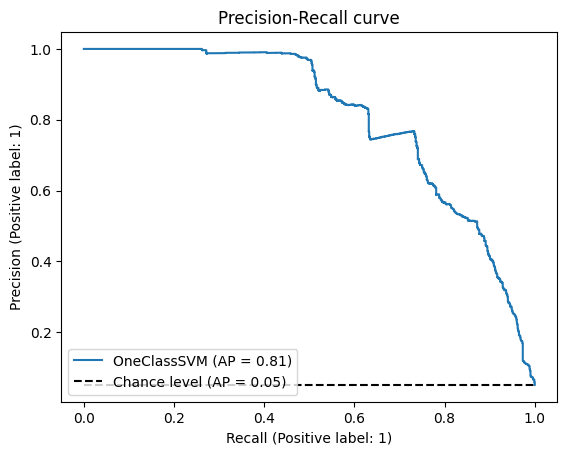

In [13]:
n_vec = [4000, 4000, 4000]

for i in range(3):

    clf.fit(X_train)
    
    y_score = clf.decision_function(X_test) * -1

    display = PrecisionRecallDisplay.from_predictions(
        y_test, y_score, name="OneClassSVM", plot_chance_level=True
    )
    _ = display.ax_.set_title("Precision-Recall curve")
    
    y_score = clf.decision_function(X_train) * -1
    
    y_train_pred = np.array([0] * len(y_train))
    y_train_pred[np.argsort(y_score)[-n_vec[i]:]] = 1
    print(confusion_matrix(y_train, y_train_pred))
    print(len(np.where((y_train == y_train_pred) & (y_train_pred == 1))[0]))
    print(len(np.where((y_train != y_train_pred) | (y_train_pred == 0))[0]))
    
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    print(X_train.shape)
    retain_index = np.where((y_train != y_train_pred) | (y_train_pred == 0))[0]
    print(len(retain_index))
    X_train = X_train.iloc[retain_index, :]
    y_train = y_train[retain_index]
    print(X_train.shape)
    print(y_train.shape)
    

In [14]:
X_train_normals = X_train[y_train == 0]
X_train_normals.shape

(77821, 62)

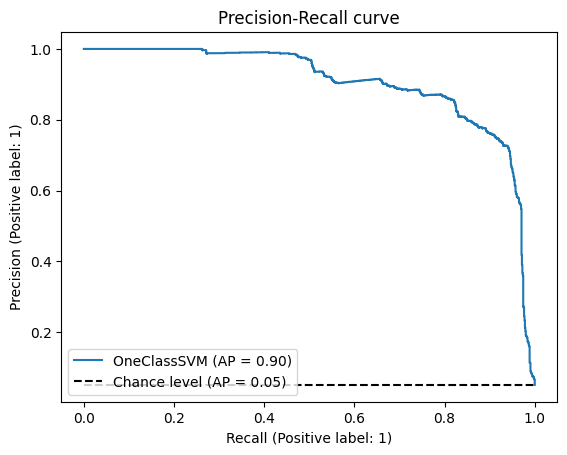

In [15]:
clf.fit(X_train_normals)
    
y_score = clf.decision_function(X_test) * -1

display = PrecisionRecallDisplay.from_predictions(
    y_test, y_score, name="OneClassSVM", plot_chance_level=True
)
_ = display.ax_.set_title("Precision-Recall curve")

In [16]:
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, 
                                                    random_state=42, stratify=df['anomaly'])

print(y_train.value_counts())
print(y_test.value_counts())

anomaly
0    77821
1     4228
Name: count, dtype: int64
anomaly
0    19456
1     1057
Name: count, dtype: int64


In [17]:
n_features = 62

# model
encoder = models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=n_features, activation='relu', input_shape=(n_features,)))
encoder.add(layers.Dropout(0.2))
encoder.add(layer=layers.Dense(units=16, activation='relu'))
encoder.add(layers.Dropout(0.2))
encoder.add(layer=layers.Dense(units=8, activation='relu'))

decoder = models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=8, activation='relu', input_shape=(8,)))
decoder.add(layers.Dropout(0.2))
decoder.add(layer=layers.Dense(units=16, activation='relu'))
decoder.add(layers.Dropout(0.2))
decoder.add(layer=layers.Dense(units=n_features, activation='sigmoid'))

autoencoder = models.Sequential([encoder, decoder])

autoencoder.compile(
    loss=losses.mean_squared_error,
    optimizer=optimizers.Adam(),
    metrics=[metrics.mean_squared_error])

autoencoder.save_weights('init.h5')

print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 62)                3906      
                                                                 
 dropout (Dropout)           (None, 62)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                1008      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
Total params: 5050 (19.73 KB)
Trainable params: 5050 (19.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "decoder"
___

In [18]:
es = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, restore_best_weights=True)

Epoch 1/10
2565/2565 [==============================] - 5s 2ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 2/10
2565/2565 [==============================] - 4s 2ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 3/10
2565/2565 [==============================] - 4s 2ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 4/10
2565/2565 [==============================] - 4s 2ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 5/10
2565/2565 [==============================] - 4s 2ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 6/10
2565/2565 [==============================] - 1s 572us/step
[[76751  1070]
 [ 1298  2930]]
2930
79119
(82049, 62)
79119
(79119, 62)
(79119,)
Epoch 1/10
2473/2473 [=======

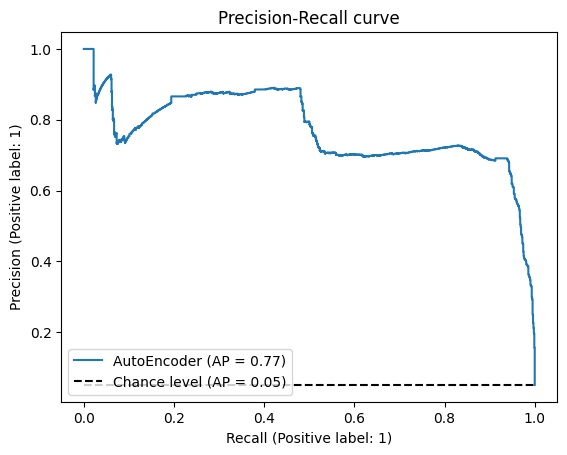

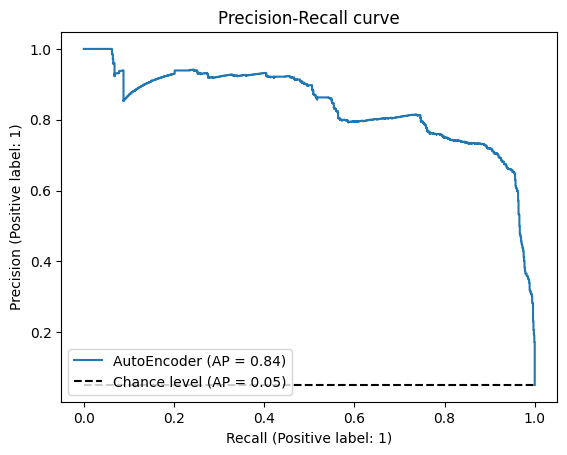

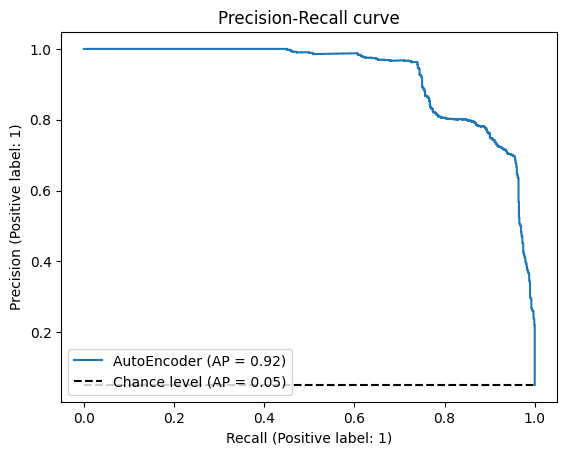

In [19]:
n_vec = [4000, 4000, 4000]

for i in range(3):
    
    autoencoder.load_weights('init.h5')

    history = autoencoder.fit(x=X_train, y=X_train, epochs=10, 
                          batch_size=32, shuffle=True, verbose=1, 
                          validation_data=(X_train, X_train), 
                          callbacks=[es])
    
    predicted_test = autoencoder.predict(x=X_test)

    y_score = losses.mean_squared_error(predicted_test, X_test)

    display = PrecisionRecallDisplay.from_predictions(
        y_test, y_score, name="AutoEncoder", plot_chance_level=True
    )
    _ = display.ax_.set_title("Precision-Recall curve")
    
    predicted_train = autoencoder.predict(x=X_train)

    y_score = losses.mean_squared_error(predicted_train, X_train)
    
    y_train_pred = np.array([0] * len(y_train))
    y_train_pred[np.argsort(y_score)[-n_vec[i]:]] = 1
    print(confusion_matrix(y_train, y_train_pred))
    print(len(np.where((y_train == y_train_pred) & (y_train_pred == 1))[0]))
    print(len(np.where((y_train != y_train_pred) | (y_train_pred == 0))[0]))
    
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    print(X_train.shape)
    retain_index = np.where((y_train != y_train_pred) | (y_train_pred == 0))[0]
    print(len(retain_index))
    X_train = X_train.iloc[retain_index, :]
    y_train = y_train[retain_index]
    print(X_train.shape)
    print(y_train.shape)
    

In [20]:
X_train_normals = X_train[y_train == 0]
X_train_normals.shape

(77821, 62)

Epoch 1/10
2432/2432 [==============================] - 4s 2ms/step - loss: 0.0205 - mean_squared_error: 0.0205 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 2/10
2432/2432 [==============================] - 4s 2ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 3/10
2432/2432 [==============================] - 4s 2ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 4/10
2432/2432 [==============================] - 4s 2ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 5/10
2432/2432 [==============================] - 4s 2ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 6/10
642/642 [==============================] - 0s 583us/step


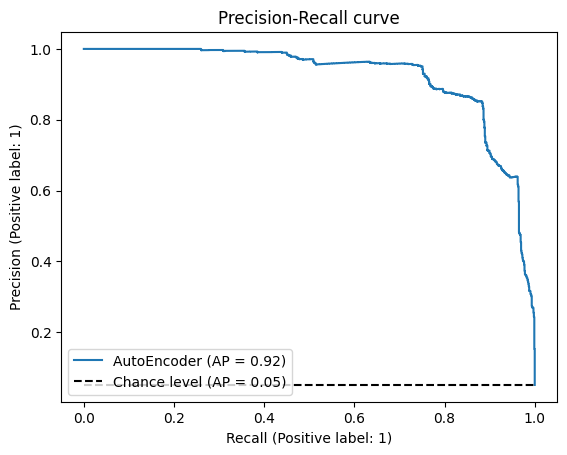

In [21]:
autoencoder.load_weights('init.h5')

es = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, restore_best_weights=True)

history = autoencoder.fit(x=X_train_normals, y=X_train_normals, epochs=10, 
                      batch_size=32, shuffle=True, verbose=1, 
                      validation_data=(X_train_normals, X_train_normals), 
                      callbacks=[es])

predicted_test = autoencoder.predict(x=X_test)

y_score = losses.mean_squared_error(predicted_test, X_test)

display = PrecisionRecallDisplay.from_predictions(
    y_test, y_score, name="AutoEncoder", plot_chance_level=True
)
_ = display.ax_.set_title("Precision-Recall curve")

In [22]:
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, 
                                                    random_state=42, stratify=df['anomaly'])

print(y_train.value_counts())
print(y_test.value_counts())

anomaly
0    77821
1     4228
Name: count, dtype: int64
anomaly
0    19456
1     1057
Name: count, dtype: int64


[[76293  1528]
 [ 1756  2472]]
2472
79577
(82049, 62)
79577
(79577, 62)
(79577,)
[[75354  2467]
 [  223  1533]]
1533
78044
(79577, 62)
78044
(78044, 62)
(78044,)
[[73884  3937]
 [  160    63]]
63
77981
(78044, 62)
77981
(77981, 62)
(77981,)


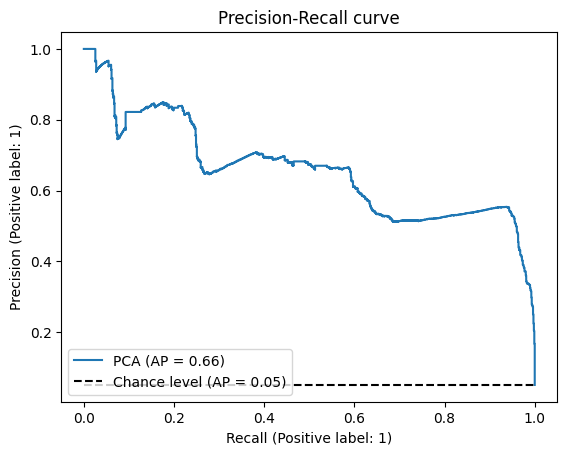

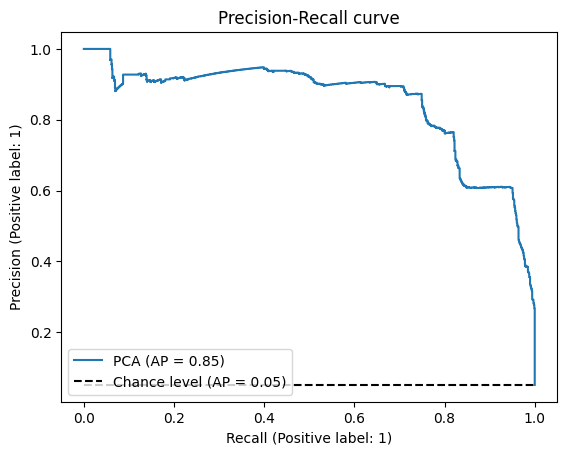

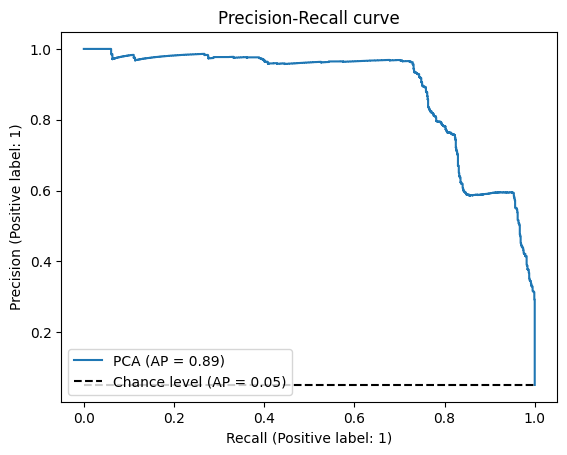

In [23]:
n_vec = [4000, 4000, 4000]

for i in range(3):
    
    pca = PCA(n_components=4, random_state=42)
    pca_train = pd.DataFrame(pca.fit_transform(X_train))
    pca_test = pd.DataFrame(pca.transform(X_test))
    
    predicted_test = pd.DataFrame(pca.inverse_transform(pca_test))

    y_score = losses.mean_squared_error(predicted_test, X_test)

    display = PrecisionRecallDisplay.from_predictions(
        y_test, y_score, name="PCA", plot_chance_level=True
    )
    _ = display.ax_.set_title("Precision-Recall curve")
    
    predicted_train = pd.DataFrame(pca.inverse_transform(pca_train))

    y_score = losses.mean_squared_error(predicted_train, X_train)
    
    y_train_pred = np.array([0] * len(y_train))
    y_train_pred[np.argsort(y_score)[-n_vec[i]:]] = 1
    print(confusion_matrix(y_train, y_train_pred))
    print(len(np.where((y_train == y_train_pred) & (y_train_pred == 1))[0]))
    print(len(np.where((y_train != y_train_pred) | (y_train_pred == 0))[0]))
    
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    print(X_train.shape)
    retain_index = np.where((y_train != y_train_pred) | (y_train_pred == 0))[0]
    print(len(retain_index))
    X_train = X_train.iloc[retain_index, :]
    y_train = y_train[retain_index]
    print(X_train.shape)
    print(y_train.shape)

In [24]:
X_train_normals = X_train[y_train == 0]
X_train_normals.shape

(77821, 62)

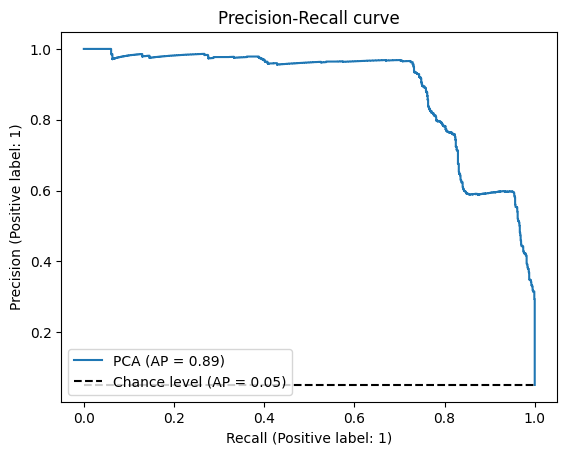

In [25]:
pca = PCA(n_components=4, random_state=42)
pca_train = pd.DataFrame(pca.fit_transform(X_train_normals))
pca_test = pd.DataFrame(pca.transform(X_test))

predicted_test = pd.DataFrame(pca.inverse_transform(pca_test))

y_score = losses.mean_squared_error(predicted_test, X_test)

display = PrecisionRecallDisplay.from_predictions(
    y_test, y_score, name="PCA", plot_chance_level=True
)
_ = display.ax_.set_title("Precision-Recall curve")

(array([   46,    50,    80, ..., 20461, 20486, 20488]),)


Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/300 [00:00<?, ?it/s]

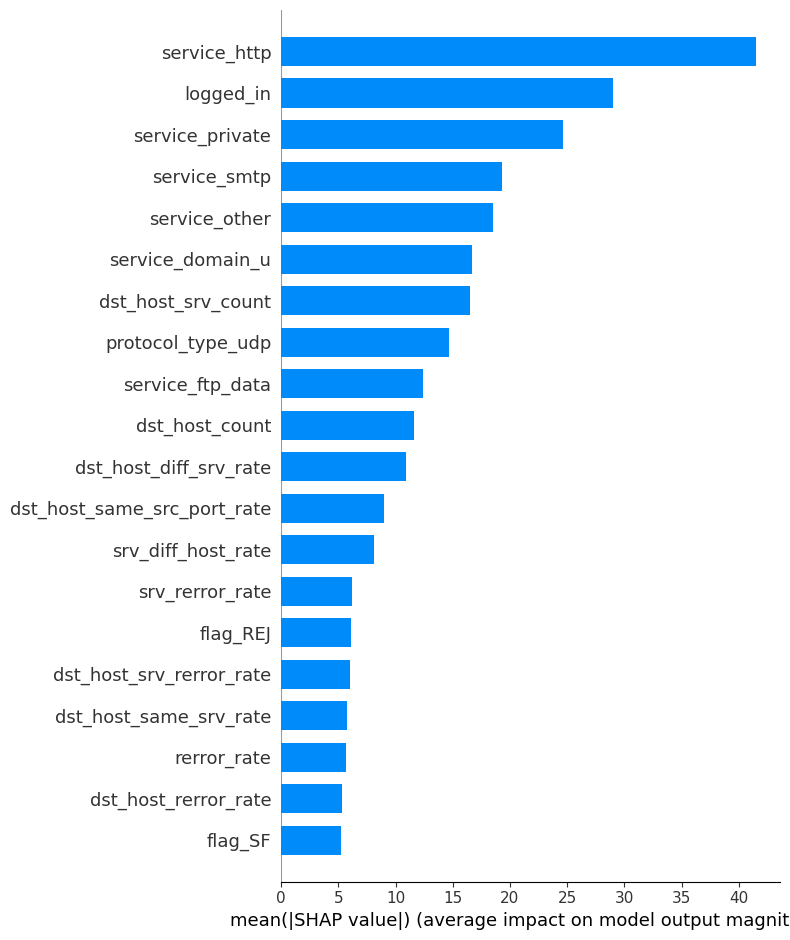

In [29]:
import shap

shap.initjs()

X_test.columns = df.columns[:-1]
print(np.where(y_test == 1))

shap_df = X_test.iloc[0:300, :]

exp = shap.KernelExplainer(clf.decision_function, shap_df) #Explainer

shap_values = exp.shap_values(shap_df, nsamples=100)  #Calculate SHAP values
shap.summary_plot(shap_values, shap_df, plot_type="bar")

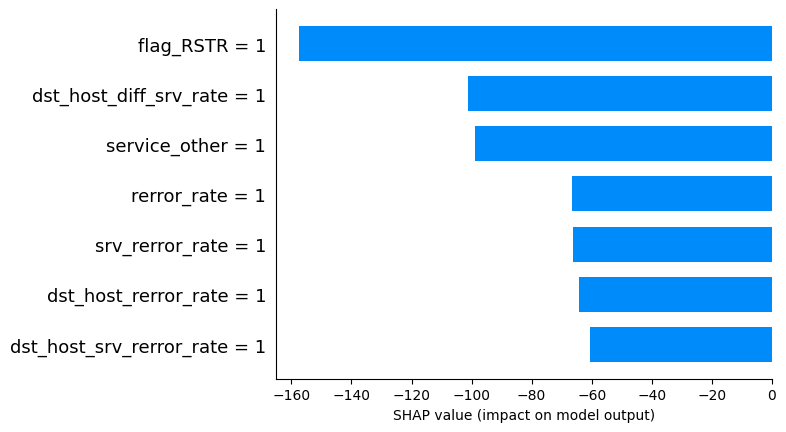

In [30]:
shap.bar_plot(shap_values[46],features =shap_df.iloc[46,:] ,feature_names =shap_df.columns )

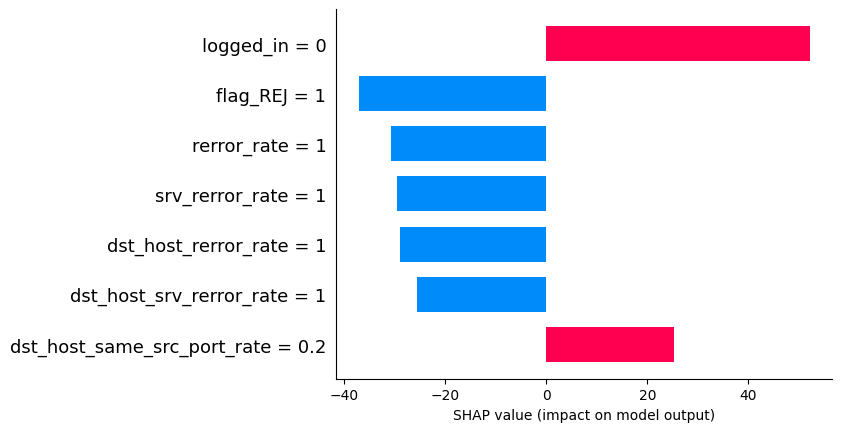

In [46]:
shap.bar_plot(shap_values[0],features =shap_df.iloc[0,:] ,feature_names =shap_df.columns )